In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import scipy as sc
import statsmodels.api as sm
import scipy.stats as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy as cp
import stormeunice as eun
import multiprocessing
import glob
import dask

sns.set_theme(style="white")
sns.set_style("white")
%matplotlib inline

random.seed(10)

# Import data

In [2]:
P1 = multiprocessing.Pool(40)

ifs_tracks = P1.map(eun.lagrangian.Lagrange.import_medr_tracks_TE, 
                    glob.glob('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_[!2]*'))

P1.close()

ifs_tracks = pd.concat(ifs_tracks)
ifs_tracks['date'] = pd.to_datetime(ifs_tracks.loc[:,['year','month','day','hour']])

## add era track in
era_track = pd.read_csv('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_2022_0',
                        skipinitialspace=True)

era_track['expid'] = 'era5'
era_track['experiment'] = 'era5'
era_track['inidate'] = pd.to_datetime('2022-01-01')
era_track['number'] = 0
era_track['date'] = pd.to_datetime(era_track.loc[:,['year','month','day','hour']])

all_tracks = pd.concat([ifs_tracks,era_track])

eunice_track = era_track.query('track_id==5')

In [3]:
ifs_tracks_filter = ifs_tracks.groupby(['track_id','inidate','experiment','number']).agg(dict(date=min, day=np.size, lon=lambda x: x.iloc[0], lat=lambda x: x.iloc[0], msl=min))
eunice_filter = eunice_track.groupby(['track_id','inidate','experiment','number']).agg(dict(date=min, day=np.size, lon=lambda x: x.iloc[0], lat=lambda x: x.iloc[0], msl=min)).iloc[0]

# starttime criterion - must be detected within 12 hours (before or after) the ERA5 track detectino time
starttime_crit = (ifs_tracks_filter.date - eunice_filter.date).dt.total_seconds().abs()<(12*60*60)
# starting location criterion - must start within 10 degrees of the ERA5 track starting point
startloc_crit = np.sqrt((ifs_tracks_filter.lon-eunice_filter.lon)**2+(ifs_tracks_filter.lat-eunice_filter.lat)**2)<10
# depth criterion - must reach a depth of at least 980 hPa
minmsl_crit = ifs_tracks_filter.msl < 98000

ifs_tracks_filtered = ifs_tracks_filter.loc[starttime_crit&startloc_crit&minmsl_crit]
ifs_eunice_list = ifs_tracks.set_index(['track_id','inidate','experiment','number']).sort_index().loc[ifs_tracks_filtered.index].reset_index()

In [4]:
multi_track_members = ifs_eunice_list.groupby(['inidate','experiment','number','track_id']).agg(dict(year = lambda x: 1)).groupby(['inidate','experiment','number']).count().query('year > 1')

for idx in multi_track_members.index:
    track_dists = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={}'.format(*idx)).groupby('track_id').apply(lambda x: eun.lagrangian.Lagrange.eunice_dist(x,eunice_track=eunice_track))
    num_reject = track_dists.idxmax()
    ifs_eunice_list_idx = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={} & track_id=={}'.format(*idx,num_reject)).index
    ifs_eunice_list = ifs_eunice_list.drop(ifs_eunice_list_idx)

In [5]:
ERA5_tracks = pd.read_hdf('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/ERA5/EU025/sfc/2022.h5')
ERA5_eunice_track = ERA5_tracks.query('uid=="202202079"')

ERA5_data = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/sfc/2022.nc').sel(time=ERA5_eunice_track.date.values)
ERA5_data['centroid_lon'] = ('time',(ERA5_eunice_track.long*4).round()/4)
ERA5_data['centroid_lat'] = ('time',(ERA5_eunice_track.lat*4).round()/4)

ERA5_eunice_stormframe = ERA5_data.groupby('time').apply(eun.lagrangian.Lagrange.lagrangian_frame)

In [6]:
%%capture 
# Ignore outputs

curr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/pl/pf/extravars/*.nc',
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe(x, ifs_eunice_list=ifs_eunice_list, sfc=False),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')
pi_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/pl/pf/extravars/*.nc',
                              preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe(x, ifs_eunice_list=ifs_eunice_list, sfc=False),
                              combine='nested',
                              concat_dim=['inidate'],
                              parallel=True, 
                              engine='netcdf4')
incr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/pl/pf/extravars/*.nc',
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe(x, ifs_eunice_list=ifs_eunice_list,sfc=False),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')

In [12]:
curr_storms

,Array,Chunk
Bytes,389.24 MiB,76.89 kiB
Shape,"(3, 1, 48, 36, 3, 81, 81)","(1, 1, 1, 1, 3, 81, 81)"
Count,65239 Tasks,5184 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,389.24 MiB,76.89 kiB
Shape,"(3, 1, 48, 36, 3, 81, 81)","(1, 1, 1, 1, 3, 81, 81)"
Count,65239 Tasks,5184 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


# Pressure surface lagrangians

## Vorticity at 850hPa

In [11]:
lev = 850
(incr_storms.vo.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.vo.sel(timestep=0, level=lev).mean('number').squeeze()).plot.contourf(col='inidate',levels=np.linspace(-5,5,11))

AttributeError: 'Dataset' object has no attribute 'vo'

## Specific humidity at 850hPa

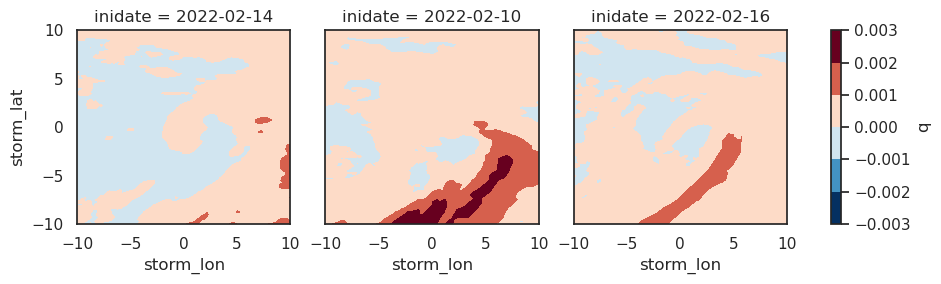

In [18]:
lev = 850
(incr_storms.q.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.q.sel(timestep=0, level=lev).mean('number').squeeze()).plot.contourf(col='inidate')

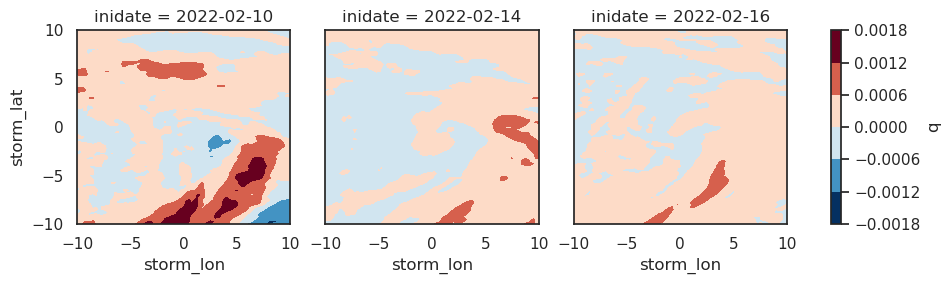

In [20]:
(curr_storms.q.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.q.sel(timestep=0, level=lev).mean('number').squeeze()).plot.contourf(col='inidate')

## Specific humidity at 500hPa

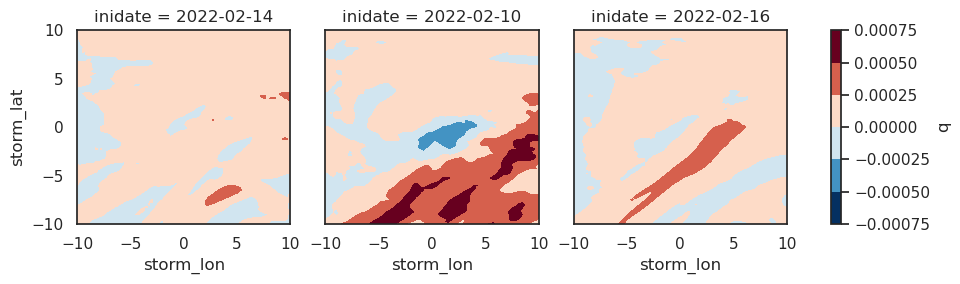

In [21]:
lev = 500
(incr_storms.q.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.q.sel(timestep=0, level=lev).mean('number').squeeze()).plot.contourf(col='inidate')

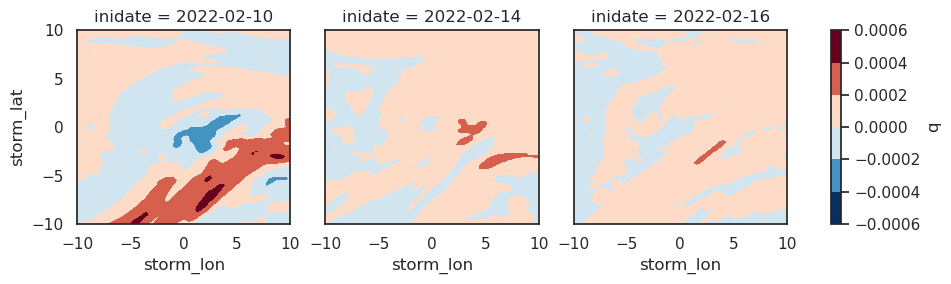

In [22]:
(curr_storms.q.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.q.sel(timestep=0, level=lev).mean('number').squeeze()).plot.contourf(col='inidate')

## Relative humidity at 850hPa

In [24]:
lev = 850
(incr_storms.r.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.r.sel(timestep=0, level=lev).mean('number').squeeze()).plot.contourf(col='inidate')